In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chaosmagpy.model_utils import design_gauss
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from alberte_klara_lib import do_design, plot_map_three
from alberte_klara_lib import n_int_max, n_ext_max, theta_grid, phi_grid
import os

from alberte_klara_lib import do_design, plot_map_three, plot_map_one, do_design_timetrend

In [4]:
data_dst = "ready_oersted_data\oersted_dark_quiet_Good_coverage.txt"
data = pd.read_table(data_dst, delimiter = ",")
data

<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\alber\AppData\Local\Temp\ipykernel_12136\1728832126.py:1: SyntaxWarning: invalid escape sequence '\o'
  data_dst = "ready_oersted_data\oersted_dark_quiet_Good_coverage.txt"


time_stamp    radius     colat       lon       B_r   B_theta    B_phi  \
0      188.172479  7107.822  103.2035 -140.3872   8815.45 -21894.13  4609.50   
1      188.173779  7121.124  109.9389 -141.6870  14158.82 -20946.59  5054.04   
2      188.174515  7128.694  113.7354 -142.4514  17041.36 -20246.59  5323.35   
3      188.175263  7136.391  117.5895 -143.2590  19862.09 -19416.86  5592.21   
4      188.175999  7143.916  121.3655 -144.0894  22499.68 -18503.82  5857.28   
...           ...       ...       ...       ...       ...       ...      ...   
26279  370.829347  7173.769   75.2560  121.2555  -7195.73 -26636.41  -348.15   
26280  370.830082  7179.484   71.5120  120.5286 -11097.43 -26077.47  -590.99   
26281  370.830818  7184.963   67.7754  119.7818 -14898.02 -25307.73  -824.74   
26282  370.831553  7190.185   64.0460  119.0095 -18520.50 -24354.34 -1019.40   
26283  370.832289  7195.129   60.3239  118.2047 -21958.27 -23210.21 -1184.33   

              X        Y         Z      dDst      Hp30             F  B_radius  
0      21894.13  4609.50  -8815.45  2.639517  1.240101  24048.130435   8815.45  
1      20946.59  5054.04 -14158.82  2.670725  1.219315  25783.233636  14158.82  
2      20246.59  5323.35 -17041.36  2.688378  1.207557  26993.895838  17041.36  
3      19416.86  5592.21 -19862.09  2.706345  1.195590  28333.546974  19862.09  
4      18503.82  5857.28 -22499.68  2.723998  1.183832  29714.216862  22499.68  
...         ...      ...       ...       ...       ...           ...       ...  
26279  26636.41  -348.15   7195.73  2.808568  1.524367  27593.442633  -7195.73  
26280  26077.47  -590.99  11097.43  2.843876  1.489057  28346.722269 -11097.43  
26281  25307.73  -824.74  14898.02  2.879183  1.453747  29378.774545 -14898.02  
26282  24354.34 -1019.40  18520.50  2.914490  1.418437  30613.427992 -18520.50  
26283  23210.21 -1184.33  21958.27  2.949798  1.383126  31973.146658 -21958.27  

[26284 rows x 14 columns]

In [5]:
nm_static = (n_int_max + 1)**2 - 1 + (n_ext_max + 1)**2 - 1
n_obs = len(data)

# lhs and rhs of lst sq prb will have to be constructed bit by bit
# allocating these in memory
lhs = np.zeros((nm_static, nm_static)) # G.T@G
rhs = np.zeros((nm_static,)) # G.T@d

# taking 10k data point at a time (sub matrix, chunk of data, G_sub) - but still all model parameters
i = 0
while (i <= n_obs - 10*10**3):
    i10k = i + 10*10**3

    G_int = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_int_max)))
    print(G_int.shape)
    G_ext = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_ext_max, source = 'external')))
    G = np.hstack((G_int, G_ext))
    lhs += G.T@G

    d = np.hstack((data['B_radius'].iloc[i:i10k], data['B_theta'].iloc[i:i10k], data['B_phi'].iloc[i:i10k]))
    rhs += G.T@d
    i += 10*10**3

G_int = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_int_max)))
G_ext = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_ext_max, source = 'external')))
G = np.hstack((G_int, G_ext))
lhs += G.T@G

d = np.hstack((data['B_radius'].iloc[i:], data['B_theta'].iloc[i:], data['B_phi'].iloc[i:]))
rhs += G.T@d


m = np.linalg.solve(lhs, rhs)

m_int_static = m[:-((n_ext_max + 1)**2 - 1)]
m_ext_static = m[-((n_ext_max + 1)**2 - 1):]

np.savetxt(os.path.join('ready_oersted_data', 'int_model_static_parameters'), m_int_static)
np.savetxt(os.path.join('ready_oersted_data', 'ext_model_static_parameters'), m_ext_static)

(30000, 195)
(30000, 195)


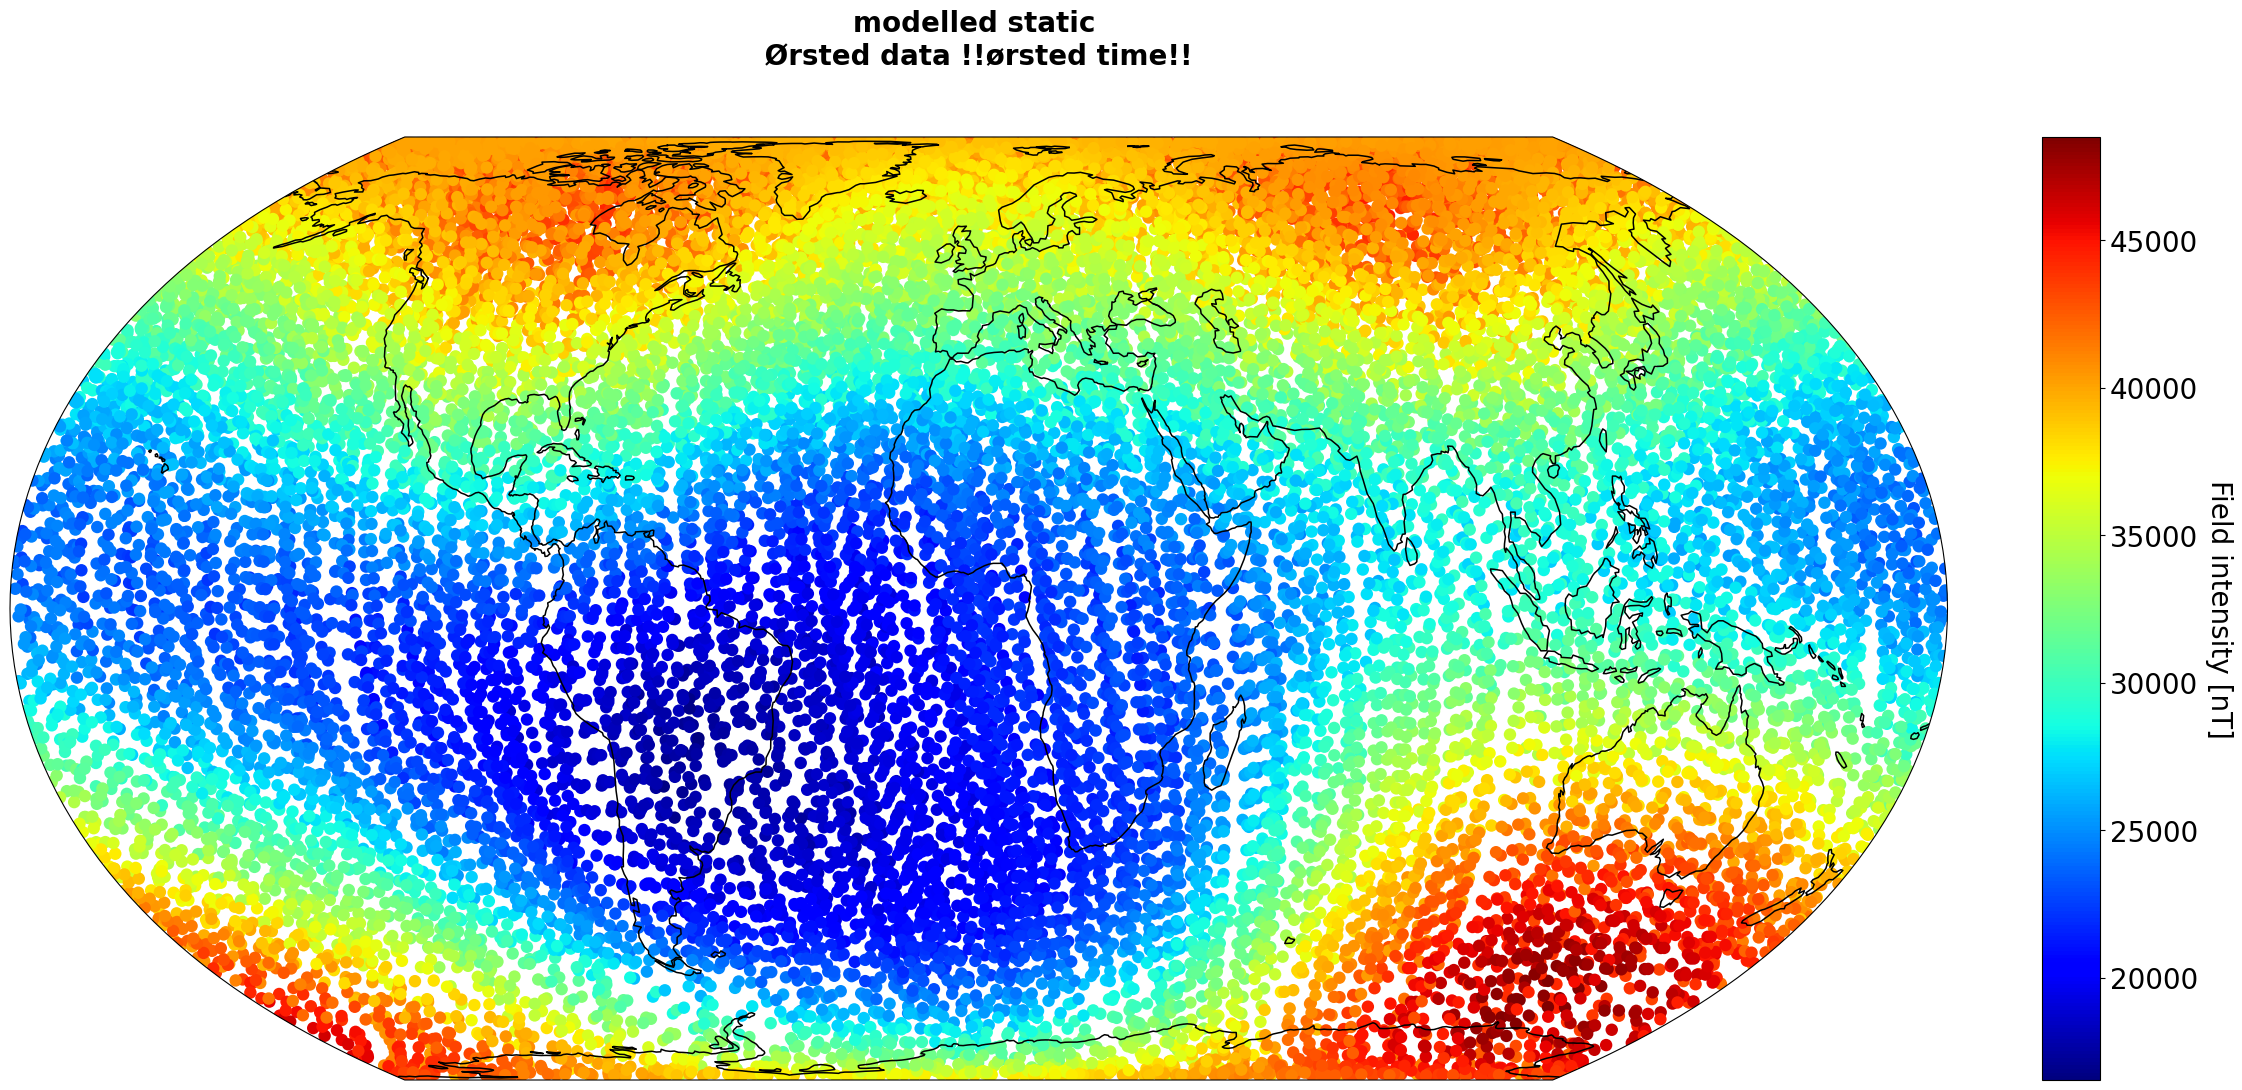

In [6]:
# Predicted field at Swarm altitude
G_pred_static_radius, G_pred_static_theta, G_pred_static_phi = do_design(data['radius'], data['colat'], data['lon'], n_int_max, n_ext_max)

b_pred_static_radius = G_pred_static_radius @ m
b_pred_static_theta = G_pred_static_theta @ m
b_pred_static_phi = G_pred_static_phi @ m

# field intensity
F_pred_static = np.sqrt(b_pred_static_radius**2 + b_pred_static_theta**2 + b_pred_static_phi**2)

plot_map_one(F_pred_static, data['lon'], data['colat'], sat='Ørsted', title='modelled static', label='Field intensity [nT]', scatter_size=80)

# Residuals between model-predicted field and measured field

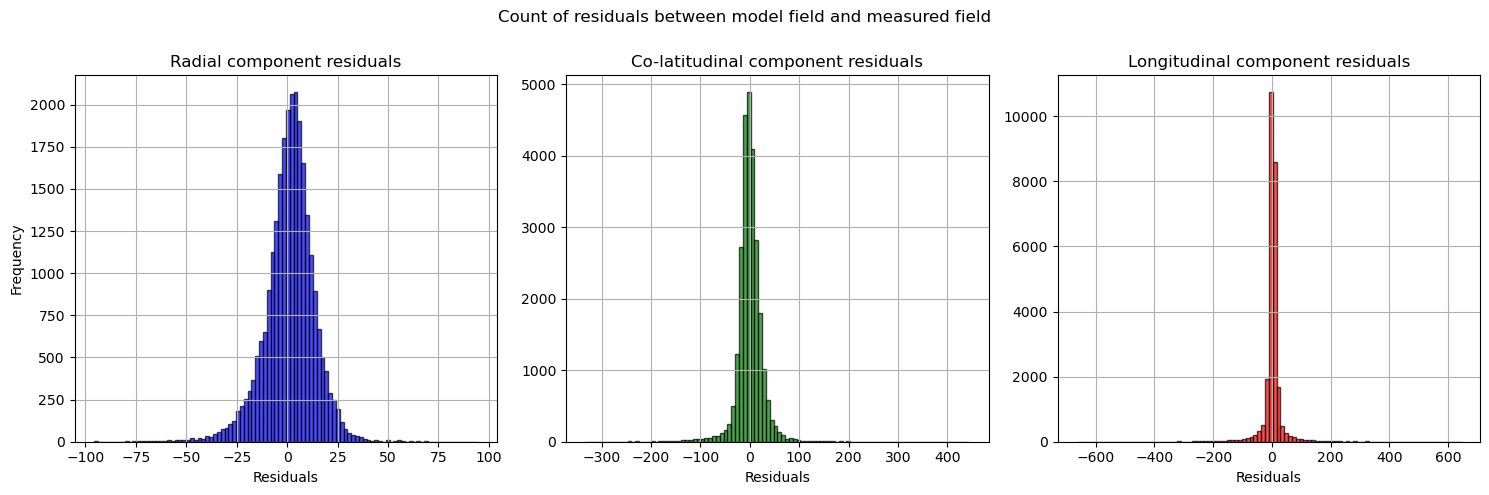

In [7]:
# Residuals
residuals_r_static = data['B_radius'] - b_pred_static_radius
residuals_t_static = data['B_theta'] - b_pred_static_theta
residuals_p_static = data['B_phi'] - b_pred_static_phi


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals')
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
# axs[1].set_ylabel('Frequency')
axs[1].set_title('Co-latitudinal component residuals')
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
# axs[2].set_ylabel('Frequency')
axs[2].set_title('Longitudinal component residuals')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field and measured field')

plt.show()

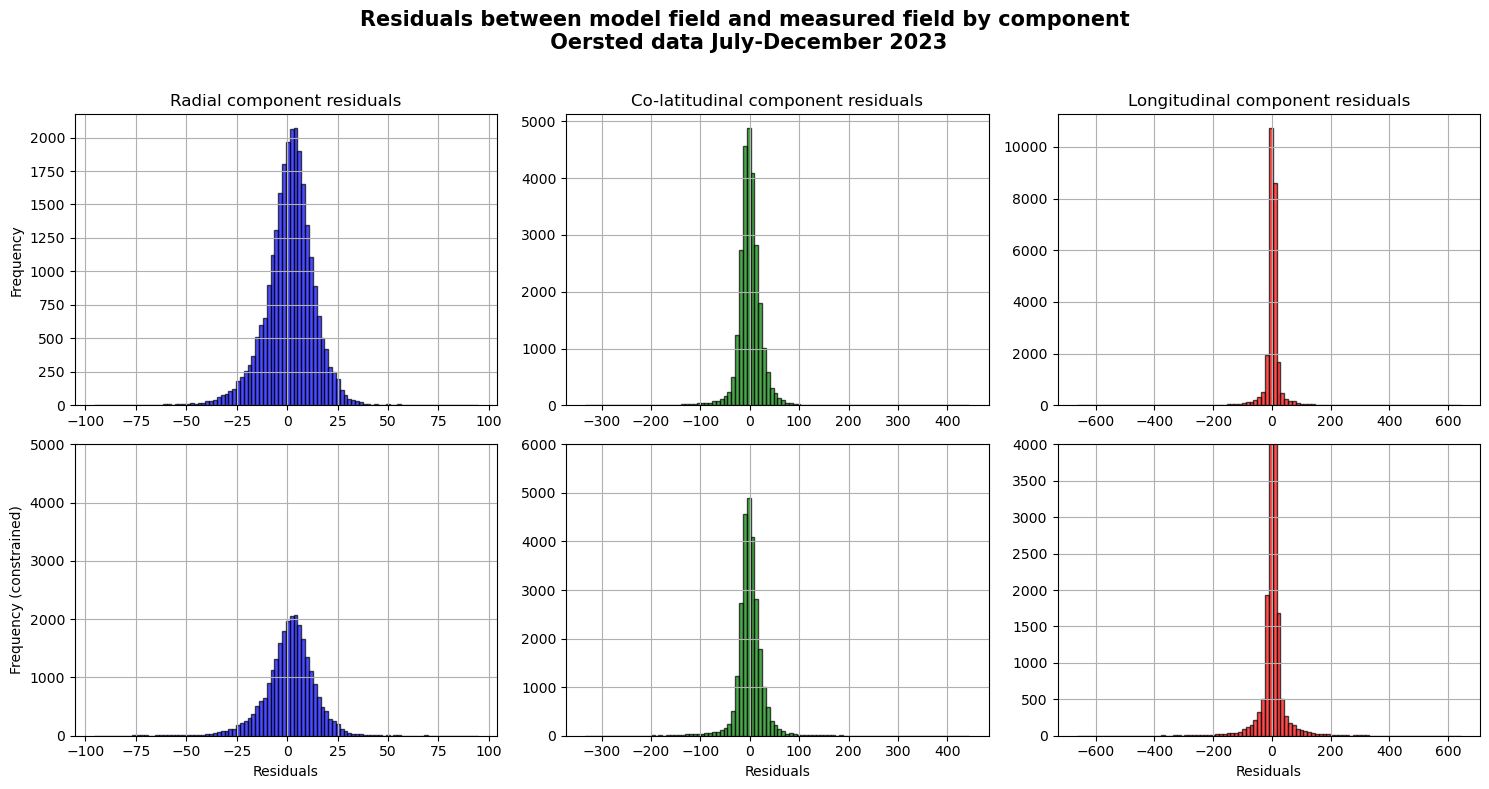

In [8]:
# Plot histogram of residuals
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

# Plot histogram of residuals_r
axs[0, 0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].set_title('Radial component residuals')
axs[0, 0].grid(True)

# Plot histogram of residuals_t
axs[0, 1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[0, 1].set_title('Co-latitudinal component residuals')
axs[0, 1].grid(True)

# Plot histogram of residuals_p
axs[0, 2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[0, 2].set_title('Longitudinal component residuals')
axs[0, 2].grid(True)

# Plot histogram of residuals_r (constrained)
axs[1, 0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[1, 0].set_xlabel('Residuals')
axs[1, 0].set_ylabel('Frequency (constrained)')
axs[1, 0].set_ylim(0, 5000)
axs[1, 0].grid(True)

# Plot histogram of residuals_t (constrained)
axs[1, 1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1, 1].set_xlabel('Residuals')
axs[1, 1].set_ylim(0, 6000)
axs[1, 1].grid(True)

# Plot histogram of residuals_p (constrained)
axs[1, 2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[1, 2].set_xlabel('Residuals')
axs[1, 2].set_ylim(0, 4000)
axs[1, 2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Residuals between model field and measured field by component\n Oersted data July-December 2023', weight = 'bold', fontsize = 15)

plt.show()

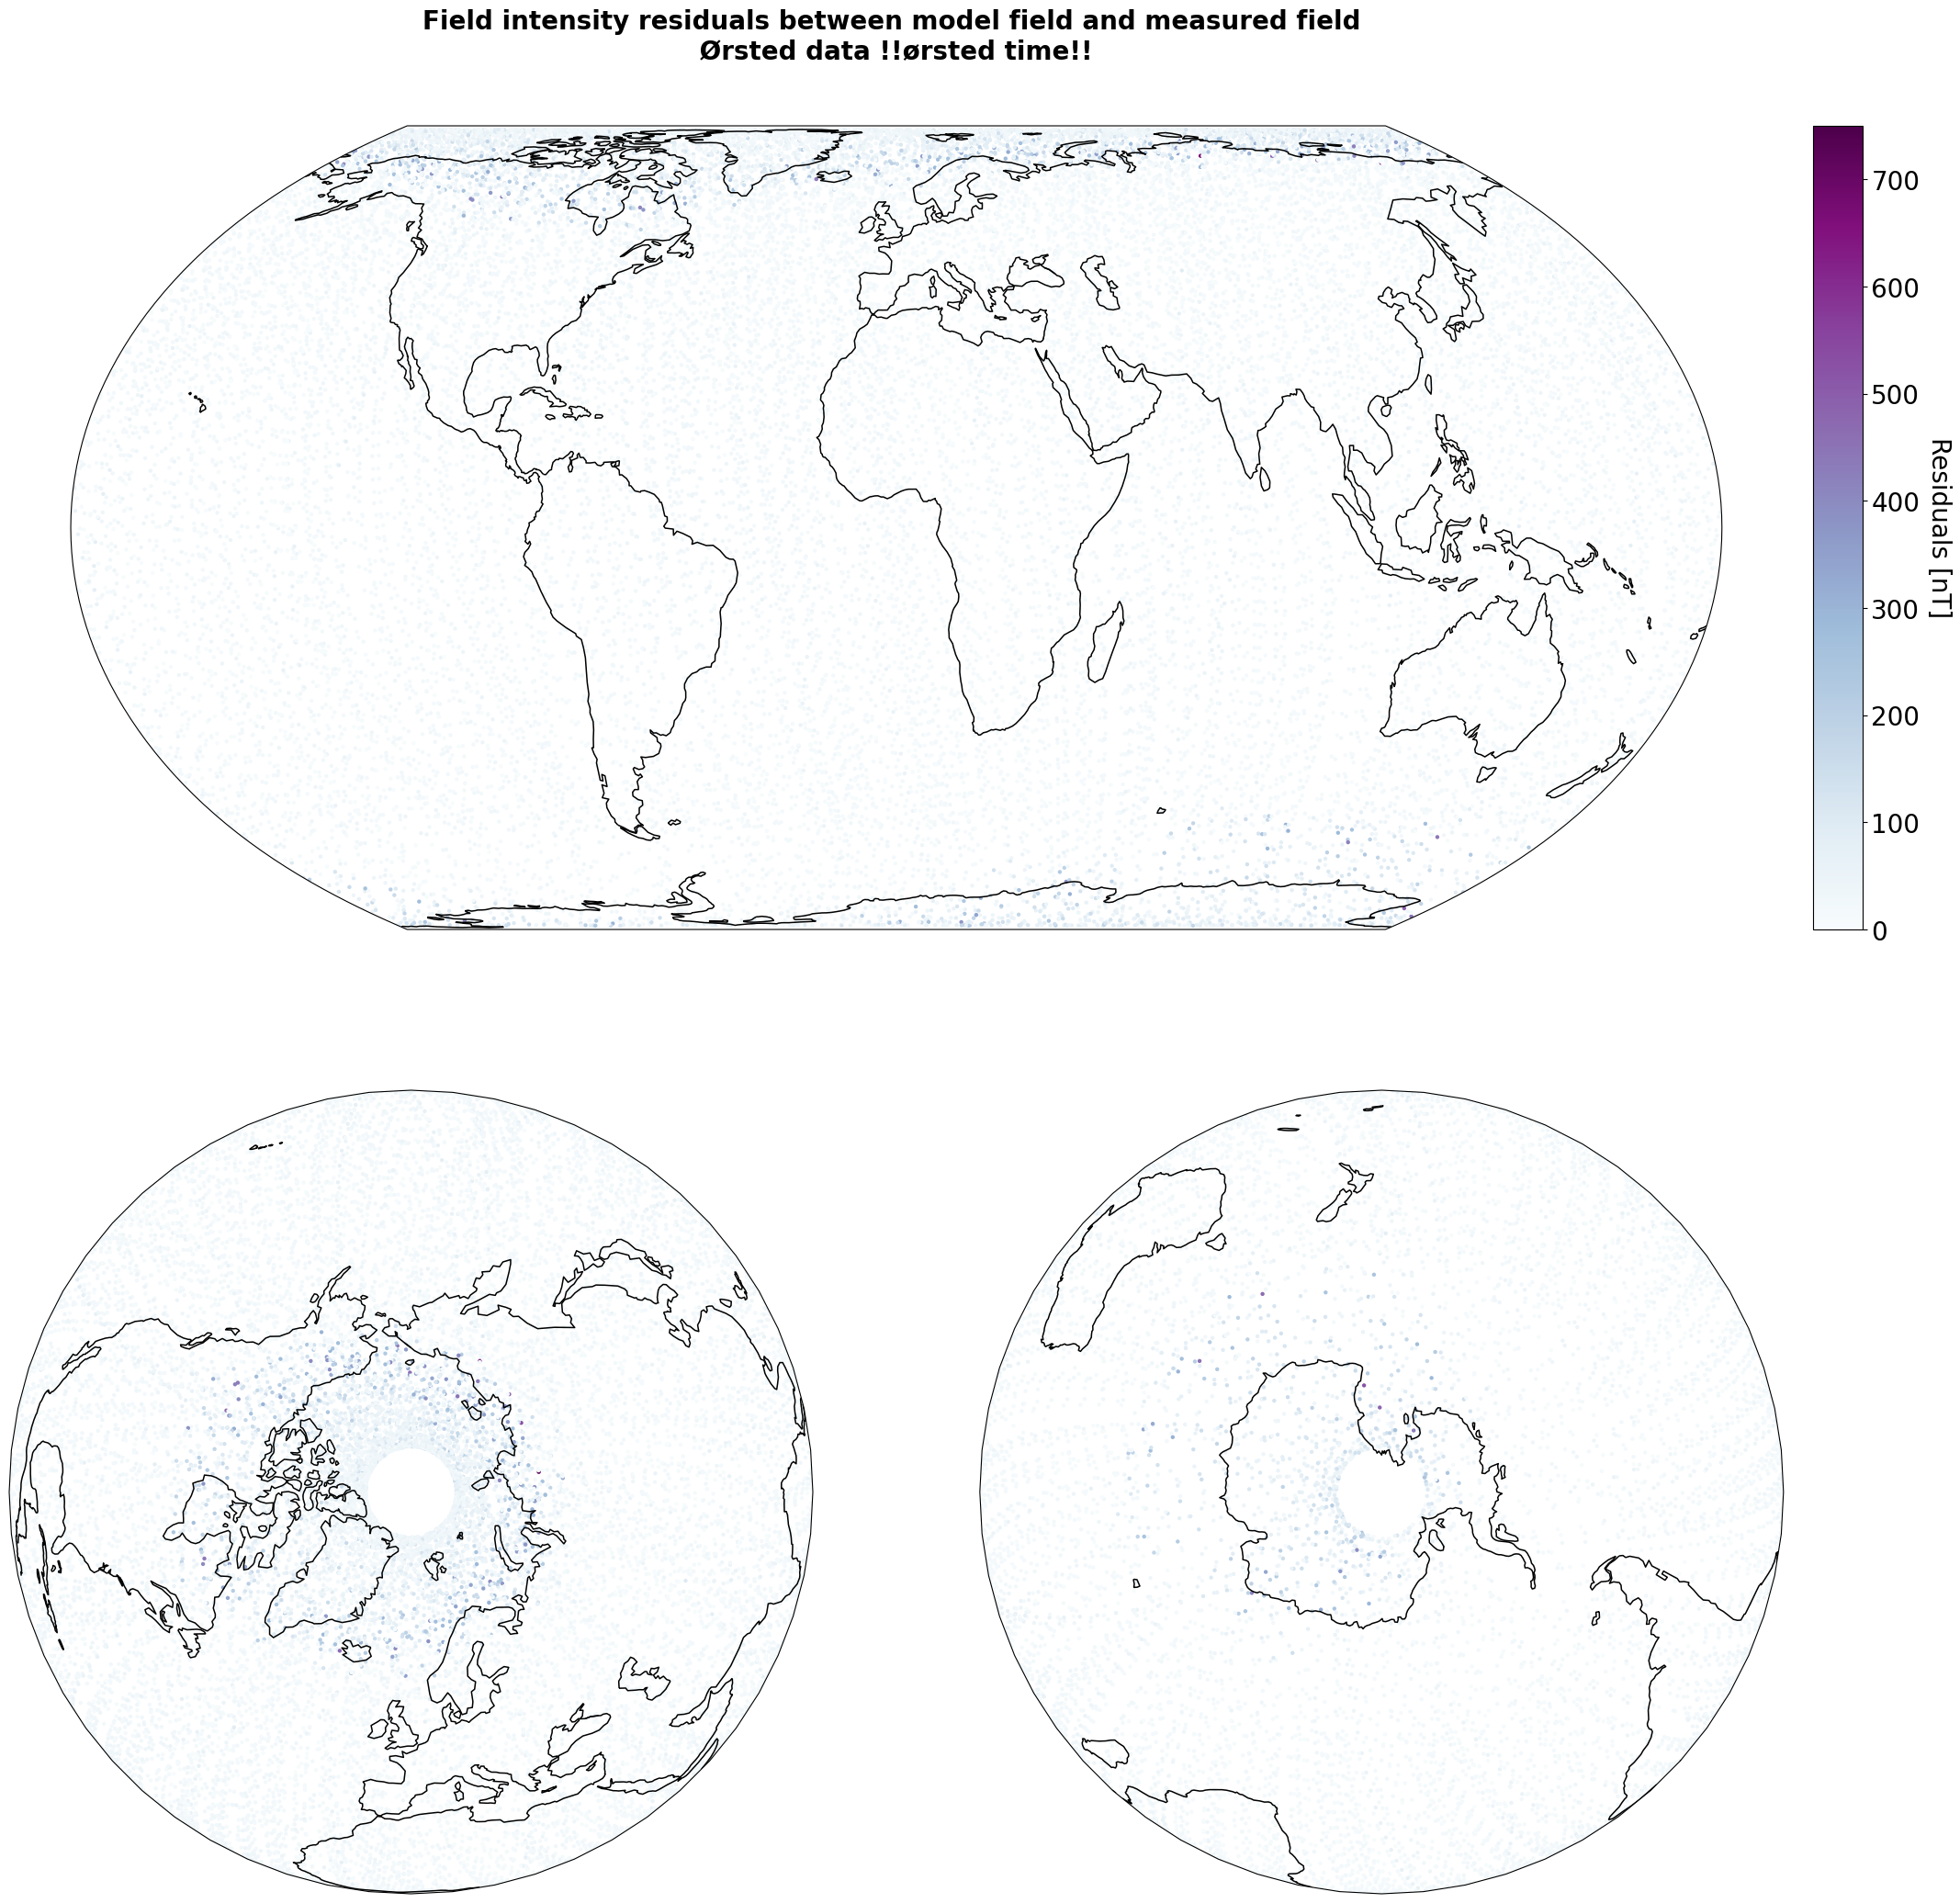

In [9]:
# Intensity of residuals on map
F_residuals = np.sqrt(residuals_r_static**2 + residuals_t_static**2 + residuals_p_static**2)

plot_map_three(F_residuals, data['lon'], data['colat'], 'Oersted', 'Field intensity residuals between model field and measured field', 'Residuals [nT]', scatter_size = 10, clim=[0, 750], colors='BuPu')

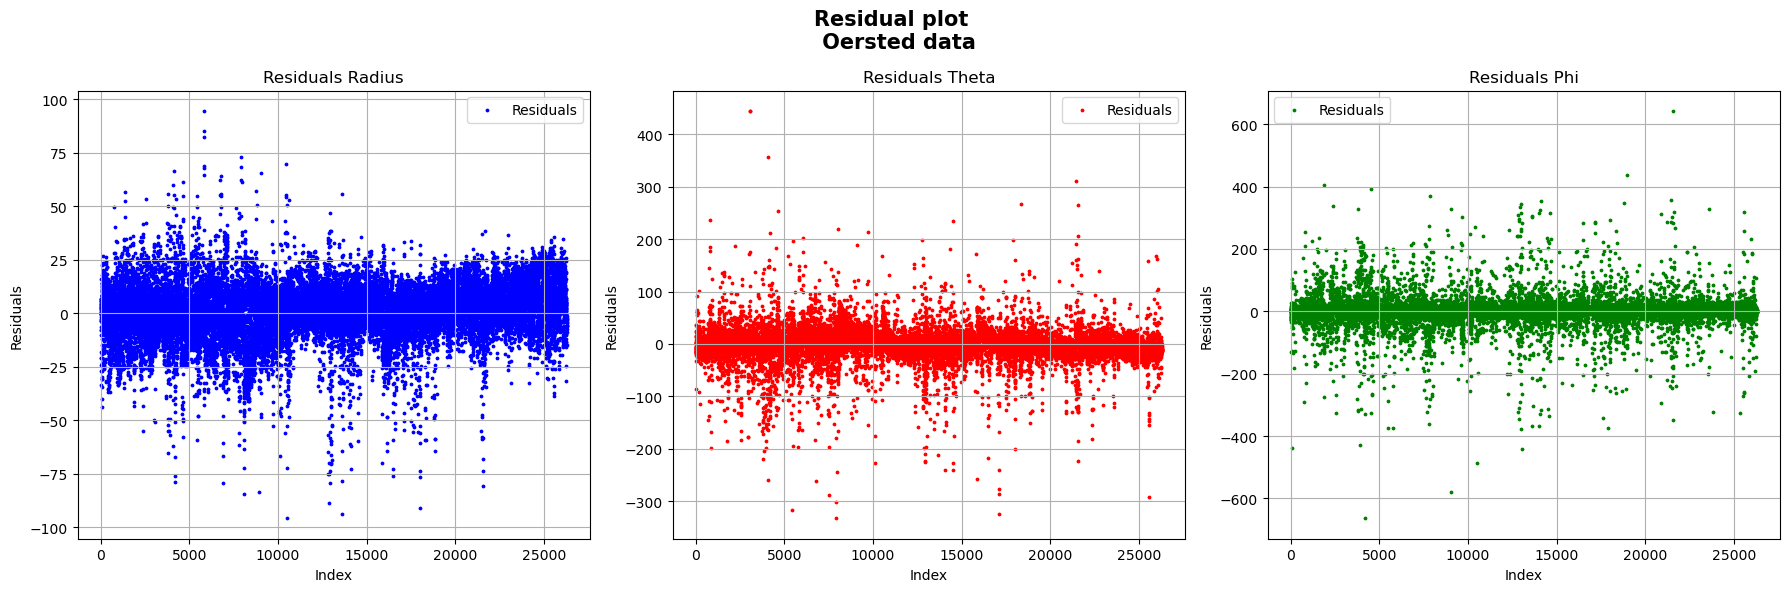

In [10]:
# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot residuals radius
axs[0].scatter(range(len(residuals_r_static)), residuals_r_static, color='blue', label='Residuals', s=3)
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Residuals Radius')
axs[0].grid(True)
axs[0].legend()

# Plot residuals theta
axs[1].scatter(range(len(residuals_t_static)), residuals_t_static, color='red', label='Residuals', s=3)
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Residuals Theta')
axs[1].grid(True)
axs[1].legend()

# Plot residuals phi
axs[2].scatter(range(len(residuals_p_static)), residuals_p_static, color='green', label='Residuals', s=3)
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Residuals')
axs[2].set_title('Residuals Phi')
axs[2].grid(True)
axs[2].legend()

fig.suptitle('Residual plot \n Oersted data', weight = 'bold', fontsize = 15)

plt.tight_layout()
plt.show()

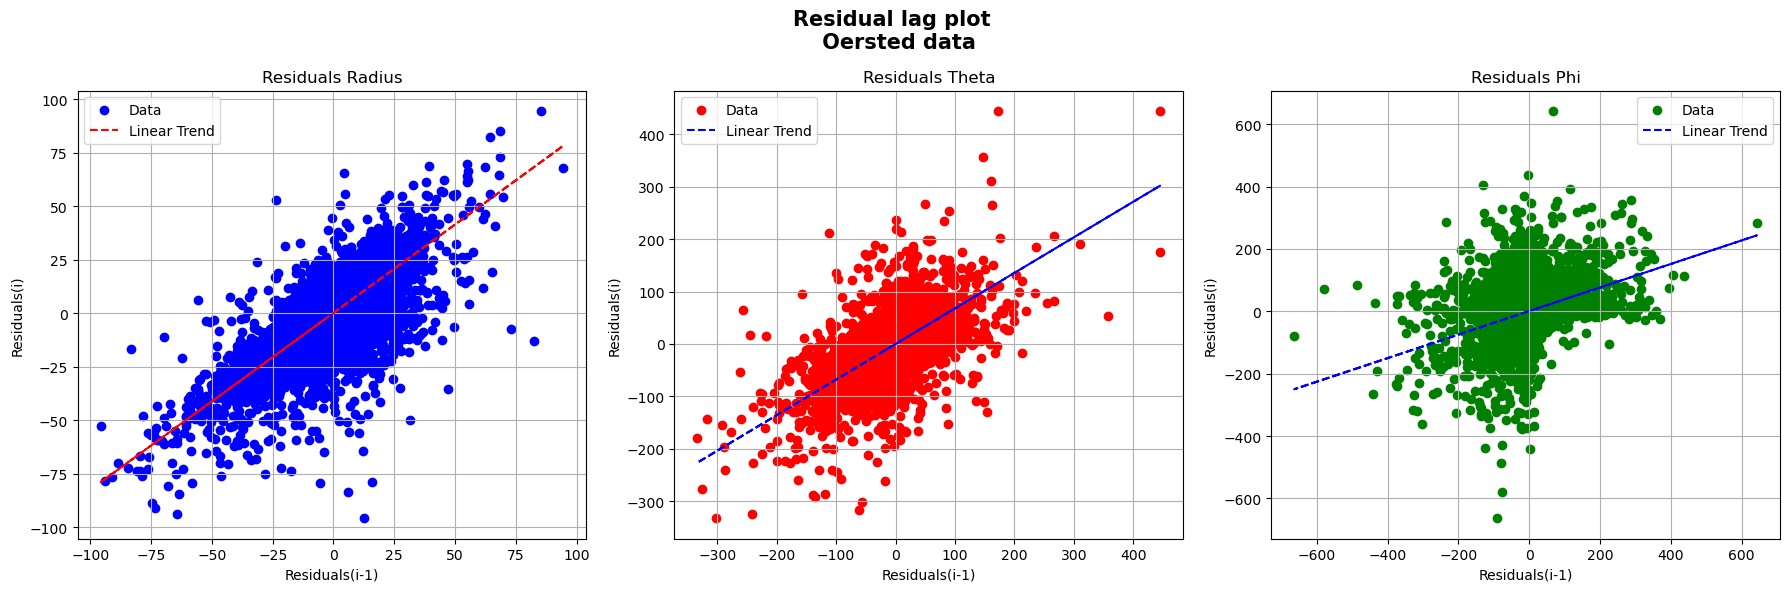

In [11]:
# Initialize lists to store residuals(i-1) and residuals(i)
residuals_r_i_minus_1 = []
residuals_r_i = []

# Iterate over the residuals data to populate the lists
for i in range(1, len(residuals_r_static)):
    residuals_r_i_minus_1.append(residuals_r_static[i - 1])
    residuals_r_i.append(residuals_r_static[i])


# Initialize lists to store residuals(i-1) and residuals(i)
residuals_t_i_minus_1 = []
residuals_t_i = []

# Iterate over the residuals data to populate the lists
for i in range(1, len(residuals_t_static)):
    residuals_t_i_minus_1.append(residuals_t_static[i - 1])
    residuals_t_i.append(residuals_t_static[i])


# Initialize lists to store residuals(i-1) and residuals(i)
residuals_p_i_minus_1 = []
residuals_p_i = []

# Iterate over the residuals data to populate the lists
for i in range(1, len(residuals_p_static)):
    residuals_p_i_minus_1.append(residuals_p_static[i - 1])
    residuals_p_i.append(residuals_p_static[i])



# Create a figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot residuals radius
axs[0].scatter(residuals_r_i_minus_1, residuals_r_i, color='blue', label='Data')
trend_line_r = np.poly1d(np.polyfit(residuals_r_i_minus_1, residuals_r_i, 1))
axs[0].plot(residuals_r_i_minus_1, trend_line_r(residuals_r_i_minus_1), color='red', linestyle='--', label='Linear Trend')
axs[0].set_xlabel('Residuals(i-1)')
axs[0].set_ylabel('Residuals(i)')
axs[0].set_title('Residuals Radius')
axs[0].grid(True)
axs[0].legend()

# Plot residuals theta
axs[1].scatter(residuals_t_i_minus_1, residuals_t_i, color='red', label='Data')
trend_line_t = np.poly1d(np.polyfit(residuals_t_i_minus_1, residuals_t_i, 1))
axs[1].plot(residuals_t_i_minus_1, trend_line_t(residuals_t_i_minus_1), color='blue', linestyle='--', label='Linear Trend')
axs[1].set_xlabel('Residuals(i-1)')
axs[1].set_ylabel('Residuals(i)')
axs[1].set_title('Residuals Theta')
axs[1].grid(True)
axs[1].legend()

# Plot residuals phi
axs[2].scatter(residuals_p_i_minus_1, residuals_p_i, color='green', label='Data')
trend_line_p = np.poly1d(np.polyfit(residuals_p_i_minus_1, residuals_p_i, 1))
axs[2].plot(residuals_p_i_minus_1, trend_line_p(residuals_p_i_minus_1), color='blue', linestyle='--', label='Linear Trend')
axs[2].set_xlabel('Residuals(i-1)')
axs[2].set_ylabel('Residuals(i)')
axs[2].set_title('Residuals Phi')
axs[2].grid(True)
axs[2].legend()


fig.suptitle('Residual lag plot \n Oersted data', weight = 'bold', fontsize = 15)
plt.tight_layout()
plt.show()

# Model with temporal gradient - linear trend of secular variation


In [14]:
t0_exact = data['time_stamp'].iloc[0] + (data['time_stamp'].iloc[-1] - data['time_stamp'].iloc[0])/2 # exact midpoint considering start and end time. matches no
# must manipulate with time stamp because data points have been removed
t = np.floor(round(data['time_stamp'], 2)*10)/10
t0_idx = np.where(t == round(t0_exact, 1))[0][-1] # -0.1 because there are no matches prior to this
t0 = data['time_stamp'].iloc[t0_idx]
print("t0 = " + str(t0) + " at index " + str(t0_idx))

# temporal gradient
data['time_grad'] = data['time_stamp'] - t0

G_pred_radius1, G_pred_theta1, G_pred_phi1 = do_design_timetrend(data['radius'], data['colat'], data['lon'], n_int_max, n_ext_max, data['time_grad'].values)

t0 = 279.59453591 at index 8429


In [17]:
nm = ((n_int_max + 1)**2 - 1)*2 + (n_ext_max + 1)**2 - 1

# lhs and rhs of lst sq prb will have to be constructed bit by bit
# allocating these in memory
lhs = np.zeros((nm, nm)) # G.T@G
rhs = np.zeros((nm,)) # G.T@d

# taking 10k data point at a time (sub matrix, chunk of data, G_sub)
i = 0
while (i <= n_obs - 10*10**3):
    i10k = i + 10*10**3

    G_int_static = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_int_max)))
    G_ext = np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], nmax=n_ext_max, source = 'external')))
    G_int_sec = ((np.vstack((design_gauss(data['radius'].iloc[i:i10k], data['colat'].iloc[i:i10k], data['lon'].iloc[i:i10k], 
                                          nmax=n_int_max))).T)*np.tile(data['time_grad'].iloc[i:i10k], 3)).T
    G = np.hstack((G_int_static, G_ext, G_int_sec))
    lhs += G.T@G

    d = np.hstack((data['B_radius'].iloc[i:i10k], data['B_theta'].iloc[i:i10k], data['B_phi'].iloc[i:i10k]))
    rhs += G.T@d
    i += 10*10**3

G_int_static = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_int_max)))
G_ext = np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_ext_max, source = 'external')))
G_int_sec = ((np.vstack((design_gauss(data['radius'].iloc[i:], data['colat'].iloc[i:], data['lon'].iloc[i:], nmax=n_int_max))).T)*np.tile(data['time_grad'].iloc[i:], 3)).T
G = np.hstack((G_int_static, G_ext, G_int_sec))
lhs += G.T@G

d = np.hstack((data['B_radius'].iloc[i:], data['B_theta'].iloc[i:], data['B_phi'].iloc[i:]))
rhs += G.T@d

In [18]:
m_all = np.linalg.solve(lhs, rhs)


m_int = m_all[:(n_int_max + 1)**2 - 1] + m_all[-((n_int_max + 1)**2 - 1):]
m_ext = m_all[(n_int_max + 1)**2 - 1:nm_static]

print(m_all.shape)


(393,)


In [19]:
b_pred_radius = G_pred_radius1 @ m_all
b_pred_theta = G_pred_theta1 @ m_all
b_pred_phi = G_pred_phi1 @ m_all

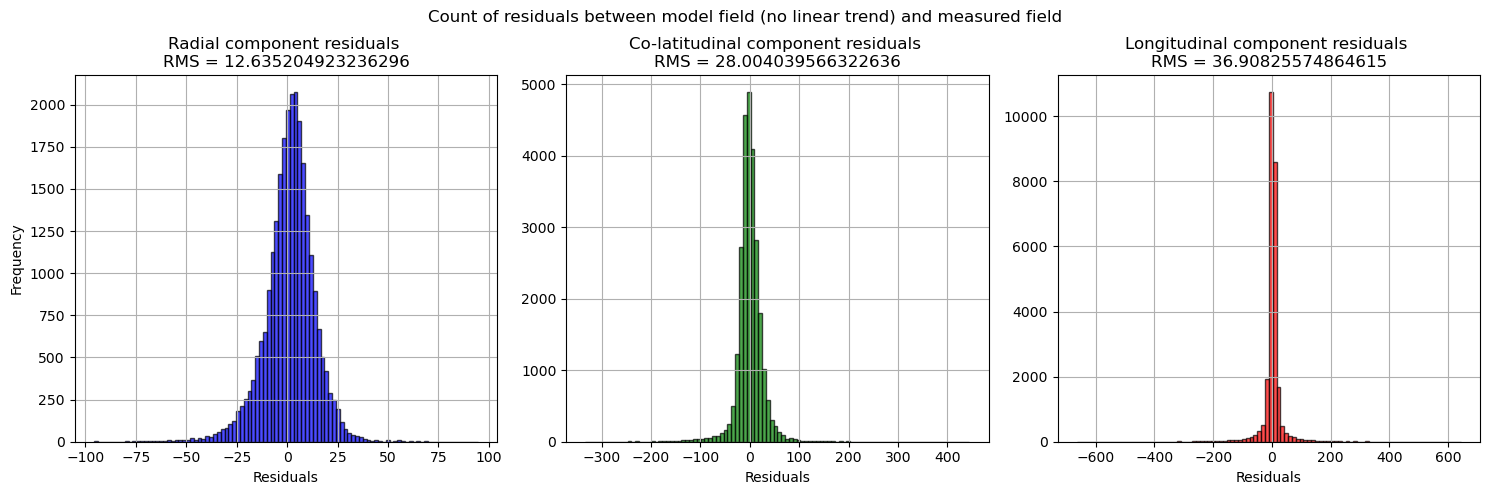

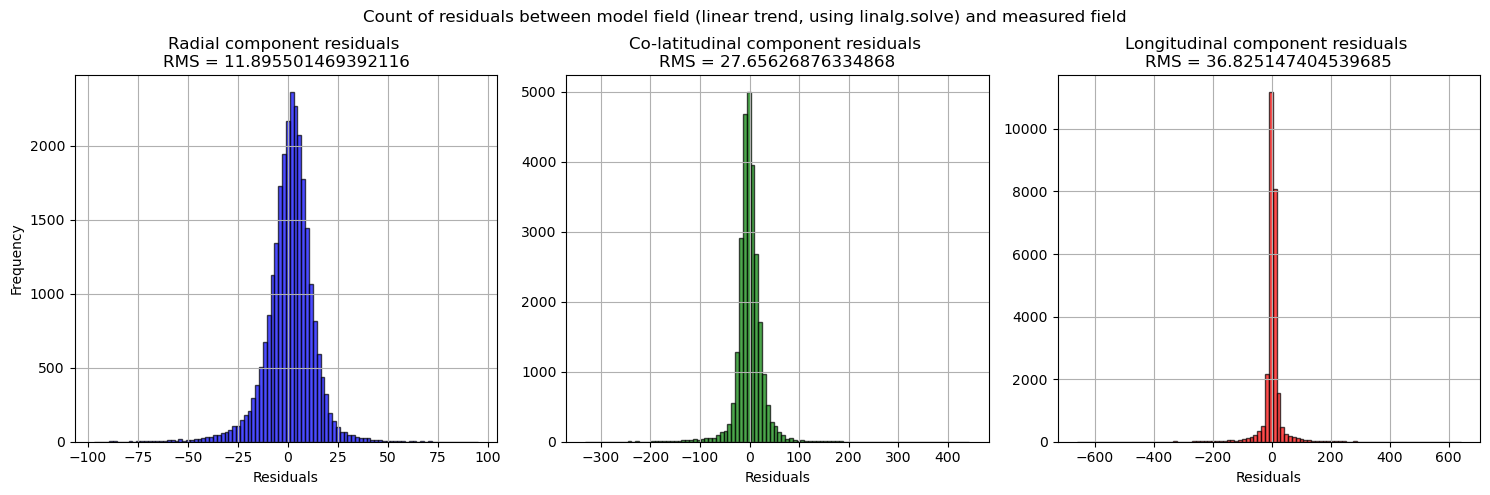

In [22]:
residuals_r = data['B_radius'] - b_pred_radius
residuals_t = data['B_theta'] - b_pred_theta
residuals_p = data['B_phi'] - b_pred_phi




# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r_static, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_r_static**2))))
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t_static, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
axs[1].set_title('Co-latitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_t_static**2))))
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p_static, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
axs[2].set_title('Longitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_p_static**2))))
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field (no linear trend) and measured field')

plt.show()


# Plot histogram of residuals
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histogram of residuals_r
axs[0].hist(residuals_r, bins=100, color='blue', edgecolor='black', alpha=0.7)
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Radial component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_r**2))))
axs[0].grid(True)

# Plot histogram of residuals_t
axs[1].hist(residuals_t, bins=100, color='green', edgecolor='black', alpha=0.7)
axs[1].set_xlabel('Residuals')
axs[1].set_title('Co-latitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_t**2))))
axs[1].grid(True)

# Plot histogram of residuals_p
axs[2].hist(residuals_p, bins=100, color='red', edgecolor='black', alpha=0.7)
axs[2].set_xlabel('Residuals')
axs[2].set_title('Longitudinal component residuals \nRMS = ' + str(np.sqrt(np.mean(residuals_p**2))))
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig.suptitle('Count of residuals between model field (linear trend, using linalg.solve) and measured field')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

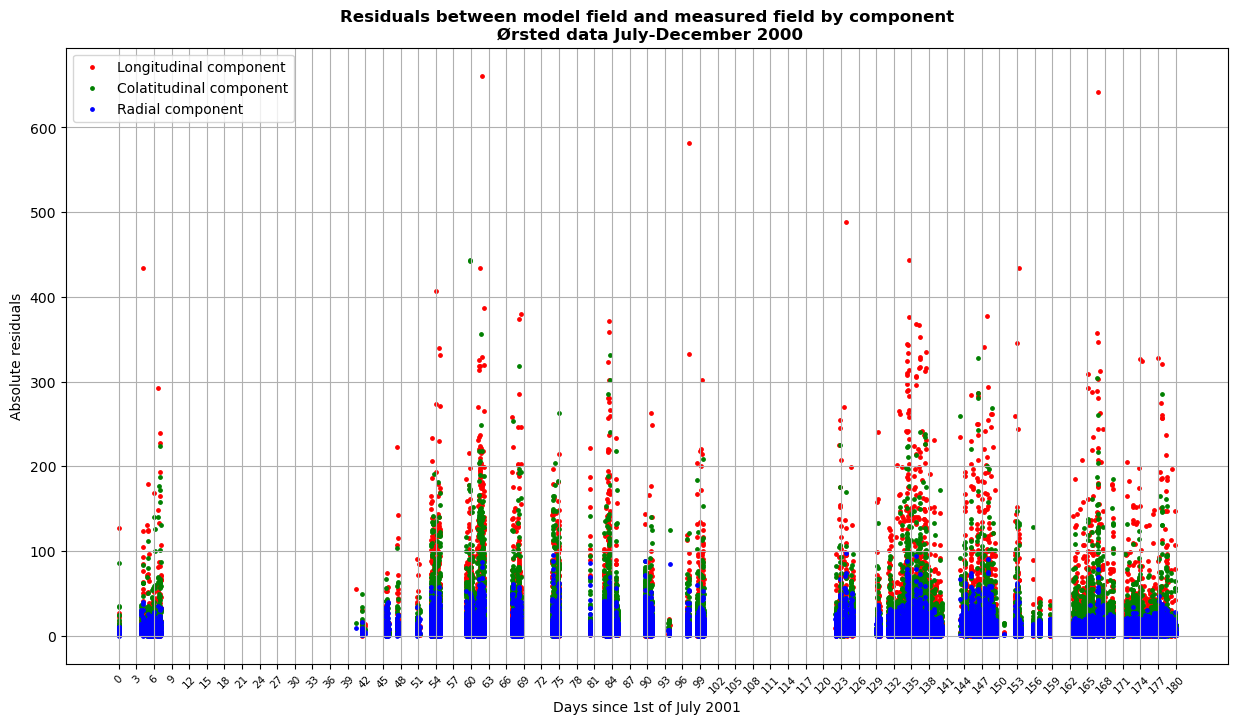

In [24]:
no_days_oersted = round(data['time_stamp'].iloc[-1] - data['time_stamp'].iloc[0])

plt.figure(figsize=(15,8))
plt.scatter(data['time_stamp'], abs(residuals_p), label = 'Longitudinal component', color = 'red', s = 6)
plt.scatter(data['time_stamp'], abs(residuals_t), label = 'Colatitudinal component', color = 'green', s = 6)
plt.scatter(data['time_stamp'], abs(residuals_r), label = 'Radial component', color = 'blue', s = 6)
plt.legend()
plt.grid()
plt.ylabel('Absolute residuals')
tick_positions = np.linspace(data['time_stamp'].iloc[0], data['time_stamp'].iloc[-1], len(range(no_days_oersted)[::3]))
plt.xticks(tick_positions, range(no_days_oersted)[::3], fontsize = 7.5, rotation = 45)
plt.xlabel('Days since 1st of July 2001')
plt.title('Residuals between model field and measured field by component\n Ørsted data July-December 2000', weight = 'bold', fontsize = 12)
plt.show

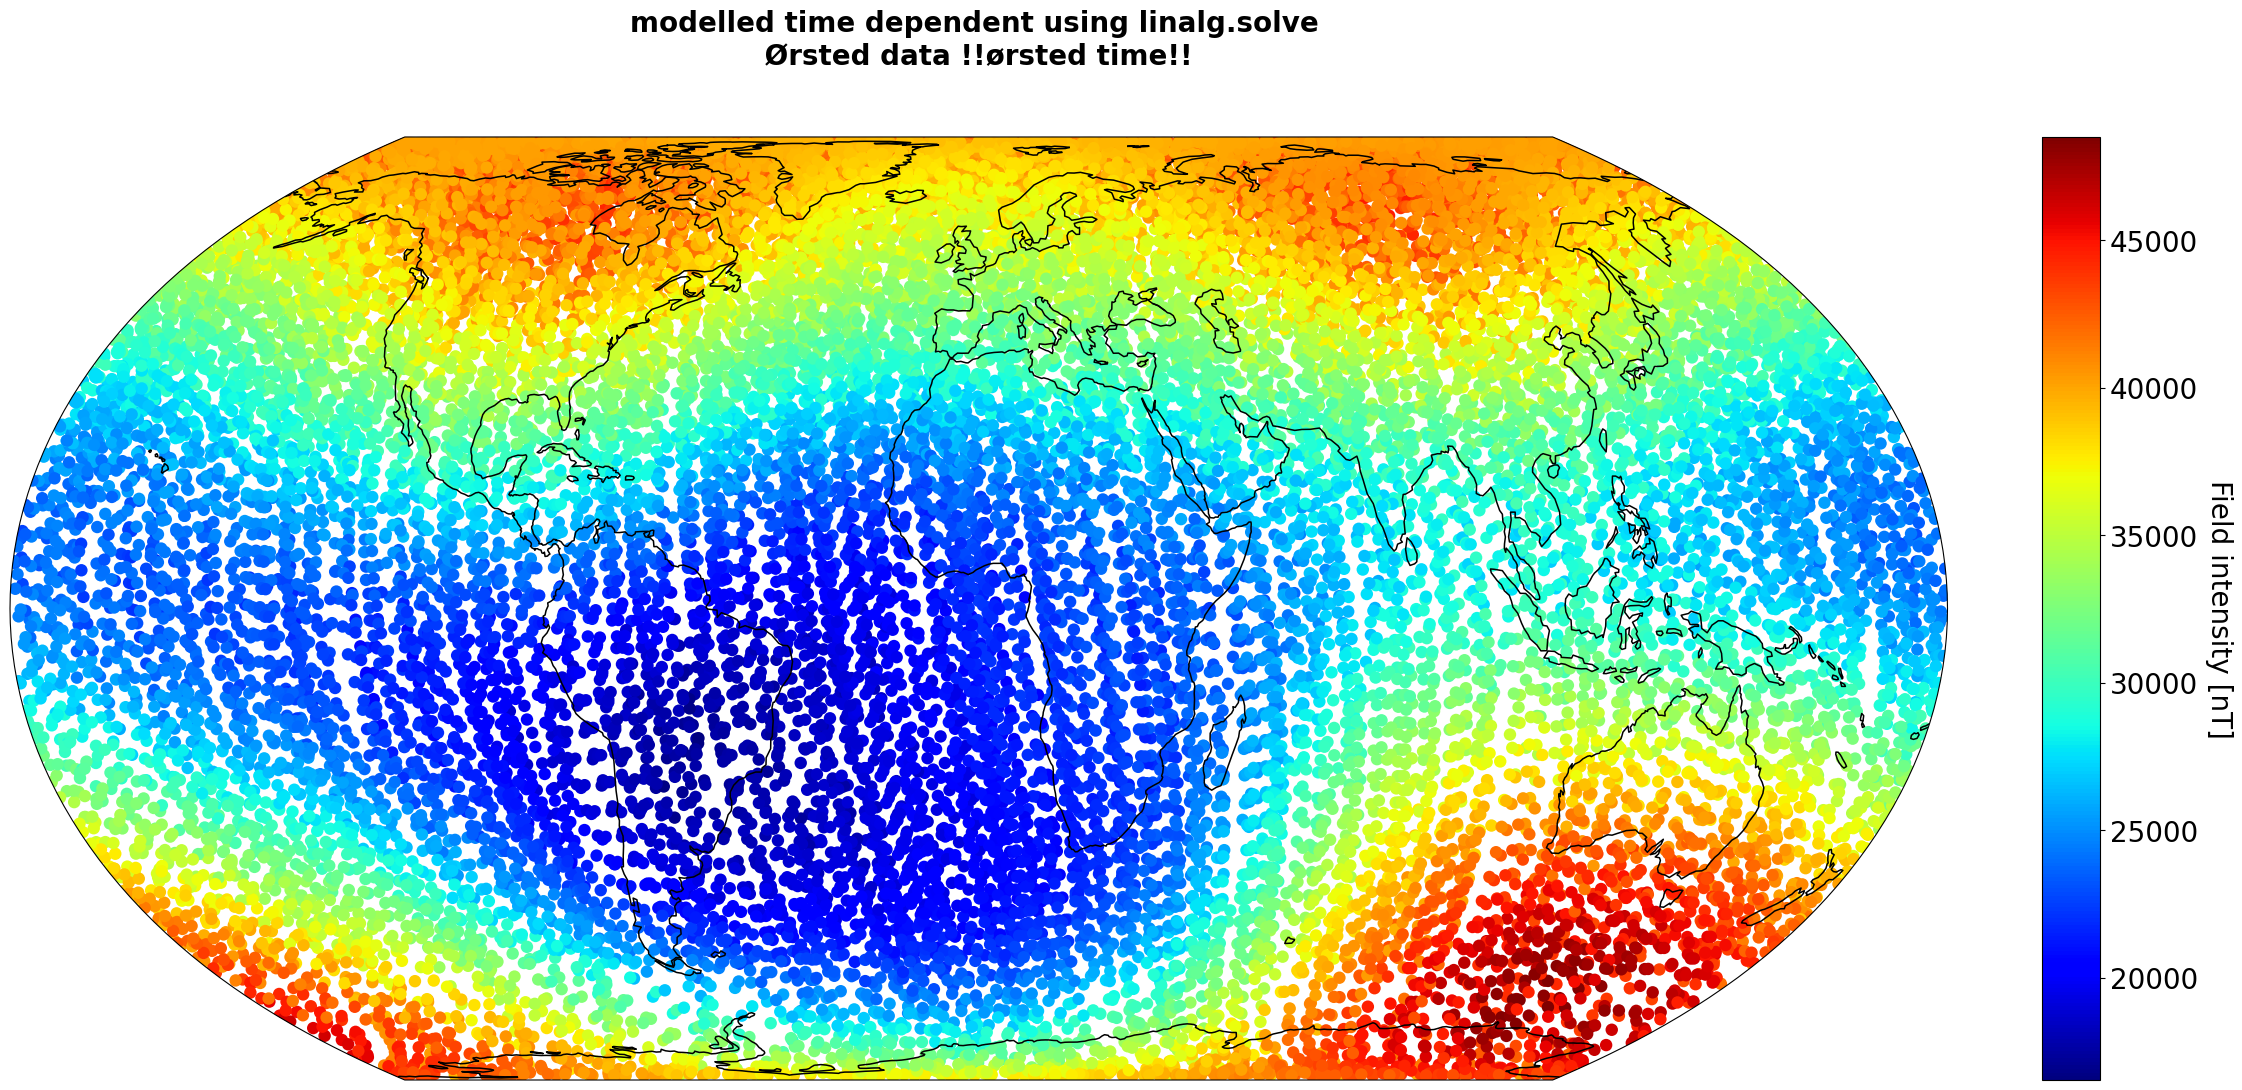

In [26]:
F_pred_time_dep = np.sqrt(b_pred_radius**2 + b_pred_theta**2 +b_pred_phi**2)

plot_map_one(F_pred_time_dep, data['lon'], data['colat'], sat='Ørsted', title='modelled time dependent using linalg.solve', label='Field intensity [nT]', scatter_size=80)